In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from survae import SurVAE, DEVICE
from survae.data import Dataset
from survae.layer import *
from survae.calibrate import *

import json

# Define dataset

In [2]:
# Why is this not in data.py? For the same reason that there is no dedicated TranspositionLayer for spatial_mnist.ipynb
# And why is that? Well, if it's okay to define a dataset here, then surely it's fine to custom-build an orthonormal layer over there.
# One might call this circular reasoning.
class Circle1D(Dataset):
    def __init__(self, radius: float = 1.0, shuffle=True, name=None):
        super().__init__(shuffle, name)

        self.r = radius
    
    def get_categories(self) -> int:
        """Not every kind of label is a one-hot encoding, Tom."""
        raise TypeError("This data doesn't have categories!")
    
    def __call__(self, n: int) -> tuple[torch.Tensor, torch.Tensor]:
        angles = torch.rand(n) * 2 * torch.pi

        X = torch.stack([
            torch.cos(angles),
            torch.sin(angles)
        ], dim=1) * self.r

        return X, torch.zeros(n)

In [3]:
RADIUS = 4
circle1d_dataset = Circle1D(radius=RADIUS)

In [148]:
X = circle1d_dataset.sample(300)

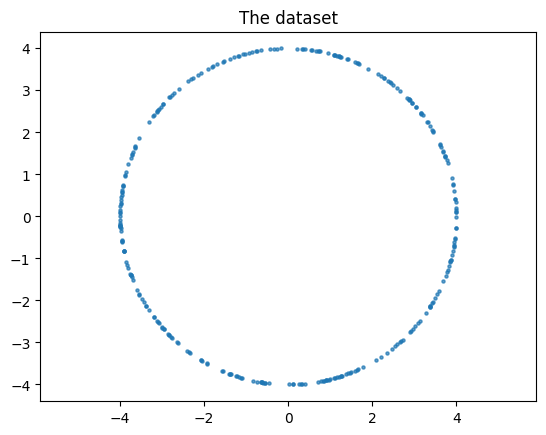

In [149]:
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), s=5, alpha=0.7)
plt.axis("equal")
plt.title("The dataset")
plt.show()

# Standard NF

In [6]:
nf_circle1d = SurVAE(
    [
        [BijectiveLayer(2, [200, 200]), OrthonormalLayer(2)]
        for _ in range(20)
    ],
    name = "NF_CIRCLE_1D"
)

In [7]:
train_log_nf = nf_circle1d.train(
    dataset=circle1d_dataset,
    batch_size=200,
    test_size=1_000,
    epochs=10_000,
    lr=1e-3,
    log_period=100,
    use_one_hot=False,
    lr_decay_params={'gamma': 0.9, 'step_size': 1_000},
    show_tqdm=True,
    save_path=None,
    record_std=True,
)

100%|██████████| 10000/10000 [10:02<00:00, 16.59it/s]


In [8]:
times_nf = list(train_log_nf.keys())
loss_train_nf = [m.training_loss for m in train_log_nf.values()]
loss_test_nf = [m.testing_loss for m in train_log_nf.values()]
sigmas_nf = [m.sigma for m in train_log_nf.values()]

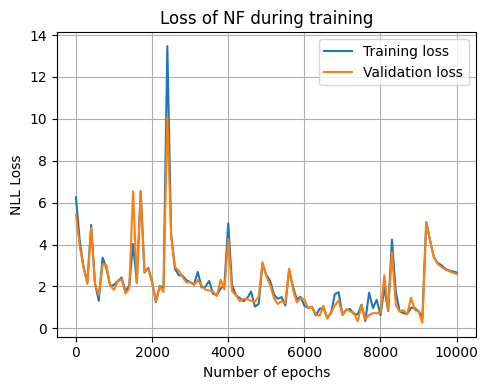

In [9]:
plt.figure(figsize=(5, 4))

plt.plot(times_nf, loss_train_nf, label='Training loss')
plt.plot(times_nf, loss_test_nf, label='Validation loss')

plt.title('Loss of NF during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
# plt.ylim(1e-10, 100)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# choose best-performing model
best_epoch = times_nf[np.argmin(loss_test_nf)]
print(f"Choosing model from epoch {best_epoch}")
nf_circle1d.load_state_dict(train_log_nf[best_epoch].model_state)

Choosing model from epoch 9101


<All keys matched successfully>

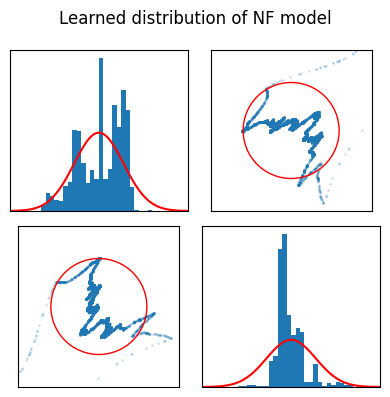

In [23]:
X = circle1d_dataset.sample(10_000)

with torch.no_grad():
    Z = nf_circle1d(X).cpu()

plot_learned_distribution(Z, f"Learned distribution of NF model")

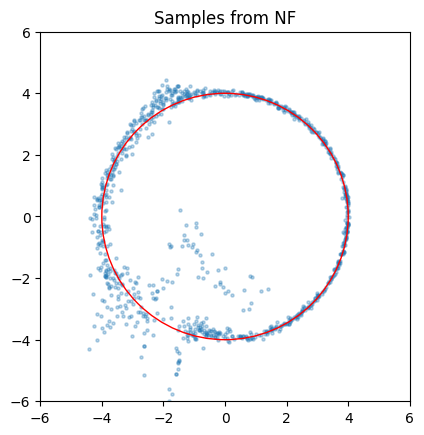

In [132]:
with torch.no_grad():
    X_hat = nf_circle1d.sample(1_000).cpu()

fig, ax = plt.subplots()

ax.scatter(X_hat[:, 0], X_hat[:, 1], s=5, alpha=0.3)
# ax.hist2d(X_hat[:, 0].numpy(), X_hat[:, 1].numpy(), bins=100)
ax.add_patch(plt.Circle((0, 0), radius=RADIUS, color='r', fill=False))

ax.set_xlim(-1.5 * RADIUS, 1.5 * RADIUS)
ax.set_ylim(-1.5 * RADIUS, 1.5 * RADIUS)

ax.set_aspect("equal")
# ax.tight_layout()
plt.title("Samples from NF")
plt.show()

# SurVAE with bottleneck

In [31]:
sv1_circle1d = SurVAE( # has bottleneck in the middle
    [
        [BijectiveLayer(2, [200, 200]), OrthonormalLayer(2)]
        for _ in range(10)
    ] +
    [SliceLayer(2, 1), Augment(1, 2)] +
    [
        [BijectiveLayer(2, [200, 200]), OrthonormalLayer(2)]
        for _ in range(10)
    ],
    name = "SV_CIRCLE_1D"
)

In [33]:
train_log_sv1 = sv1_circle1d.train(
    dataset=circle1d_dataset,
    batch_size=200,
    test_size=1_000,
    epochs=10_000,
    lr=1e-3,
    log_period=100,
    use_one_hot=False,
    lr_decay_params={'gamma': 0.9, 'step_size': 1_000},
    show_tqdm=True,
    save_path=None,
    record_std=True,
)

100%|██████████| 10000/10000 [10:13<00:00, 16.29it/s]


In [34]:
times_sv1 = list(train_log_sv1.keys())
loss_train_sv1 = [m.training_loss for m in train_log_sv1.values()]
loss_test_sv1 = [m.testing_loss for m in train_log_sv1.values()]
sigmas_sv1 = [m.sigma for m in train_log_sv1.values()]

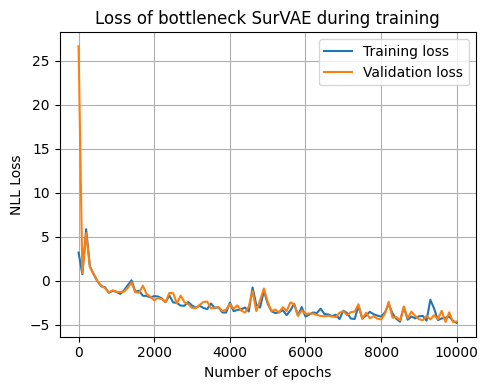

In [35]:
plt.figure(figsize=(5, 4))

plt.plot(times_sv1, loss_train_sv1, label='Training loss')
plt.plot(times_sv1, loss_test_sv1, label='Validation loss')

plt.title('Loss of bottleneck SurVAE during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
# plt.semilogy()
# plt.ylim(1e-10, 100)
plt.legend()
plt.tight_layout()
plt.show()

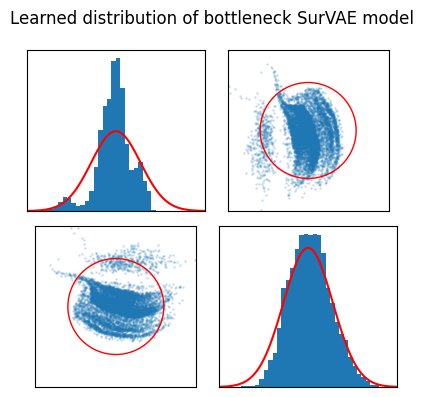

In [36]:
X = circle1d_dataset.sample(10_000)

with torch.no_grad():
    Z = sv1_circle1d(X).cpu()
    
plot_learned_distribution(Z, f"Learned distribution of bottleneck SurVAE model", axis_scale=3.6)

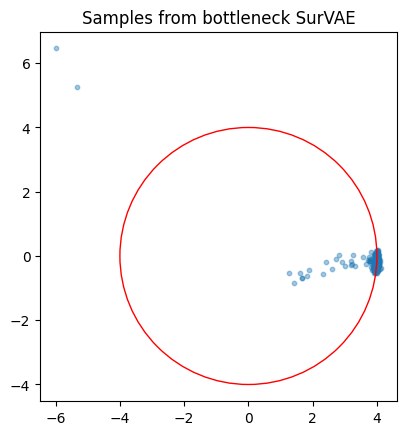

In [142]:
with torch.no_grad():
    X_hat = sv1_circle1d.sample(1_000).cpu()

fig, ax = plt.subplots()

ax.scatter(X_hat[:, 0], X_hat[:, 1], s=10, alpha=0.4)
# ax.hist2d(X_hat[:, 0].numpy(), X_hat[:, 1].numpy(), bins=100)
ax.add_patch(plt.Circle((0, 0), radius=RADIUS, color='r', fill=False))

# ax.set_xlim(-1.1 * RADIUS, 1.1 * RADIUS)
# ax.set_ylim(-1.1 * RADIUS, 1.1 * RADIUS)

ax.set_aspect("equal")
plt.title("Samples from bottleneck SurVAE")
plt.show()

# SurVAE with MaxTheLayer

In [112]:
sv2_circle1d = SurVAE( # uses Max at the end
    [
        [BijectiveLayer(2, [200, 200]), OrthonormalLayer(2)]
        for _ in range(20)
    ] +
    [MaxTheLayer(2, learn_index_probs=True, learn_sigma=True)],
    name = "SV_CIRCLE_1D"
)

In [113]:
train_log_sv2 = sv2_circle1d.train(
    dataset=circle1d_dataset,
    batch_size=200,
    test_size=1_000,
    epochs=10_000,
    lr=1e-3,
    log_period=100,
    use_one_hot=False,
    lr_decay_params={'gamma': 0.9, 'step_size': 1_000},
    show_tqdm=True,
    save_path=None,
    record_std=True,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [20:36<00:00,  8.09it/s]


In [114]:
times_sv2 = list(train_log_sv2.keys())
loss_train_sv2 = [m.training_loss for m in train_log_sv2.values()]
loss_test_sv2 = [m.testing_loss for m in train_log_sv2.values()]
sigmas_sv2 = [m.sigma for m in train_log_sv2.values()]

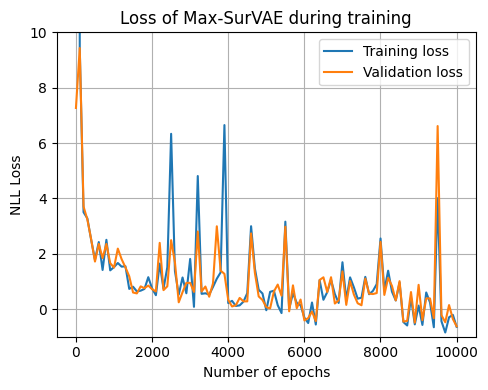

In [118]:
plt.figure(figsize=(5, 4))

plt.plot(times_sv2, loss_train_sv2, label='Training loss')
plt.plot(times_sv2, loss_test_sv2, label='Validation loss')

plt.title('Loss of Max-SurVAE during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
# plt.semilogy()
plt.ylim(-1, 10)
plt.legend()
plt.tight_layout()
plt.show()

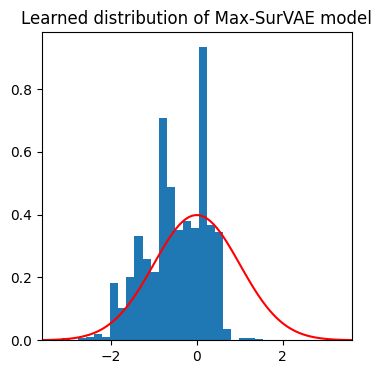

In [139]:
X = circle1d_dataset.sample(10_000)

with torch.no_grad():
    Z = sv2_circle1d(X).cpu()

x_axis = np.linspace(-3.6, 3.6, 100)
gaussian_pdf = lambda x: 1 / (1 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / 1) ** 2)
y_gaussian = gaussian_pdf(x_axis)

plt.figure(figsize=(4, 4))
plt.hist(Z, bins=50, density=True)
plt.plot(x_axis, y_gaussian, color='r')
plt.title("Learned distribution of Max-SurVAE model")
plt.xlim(-3.6, 3.6)
plt.show()

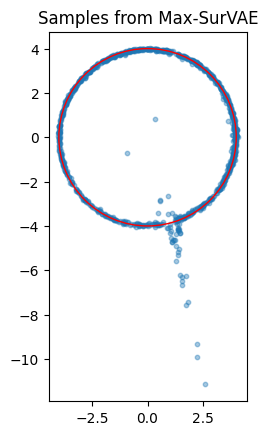

In [144]:
with torch.no_grad():
    X_hat = sv2_circle1d.sample(1_000).cpu()

fig, ax = plt.subplots()

ax.scatter(X_hat[:, 0], X_hat[:, 1], s=10, alpha=0.4)
ax.add_patch(plt.Circle((0, 0), radius=RADIUS, color='r', fill=False))

# ax.set_xlim(-1.1 * RADIUS, 1.1 * RADIUS)
# ax.set_ylim(-1.1 * RADIUS, 1.1 * RADIUS)

ax.set_aspect("equal")
plt.title("Samples from Max-SurVAE")
plt.show()

In [152]:
sv2_circle1d.layers[-1].index_probs

Parameter containing:
tensor([3.8843, 5.8779], device='cuda:0', requires_grad=True)